In [1]:
import pandas
import datetime
import numpy
from scipy.optimize import curve_fit
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams
%matplotlib inline

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean", "vSaps"], ascending=[False,True] ).reset_index(drop=True)
velCatOrderd = ['(0, 100]', '(100, 200]', '(200, 300]', '(300, 400]', '(400, 500]',\
          '(500, 600]', '(600, 700]', '(700, 800]',\
          '(800, 900]', '(900, 1000]', '(1000, 1100]', '(1100, 1200]',\
          '(1200, 1300]', '(1300, 1400]', '(1400, 1500]',\
          '(1500, 1600]', '(1600, 1700]', '(1700, 1800]',\
          '(1800, 1900]', '(1900, 2000]' ]

velGmagDF['vel_bin'] = pandas.Categorical(
    velGmagDF['vel_bin'], 
    categories=velCatOrderd, 
    ordered=True
)
# We need only a few cols
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps", "azim", "dst_index",\
                        "vel_bin", "dst_bin", "dst_mean" ] ]
velGmagDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,normMLT,MLAT,vSaps,azim,dst_index,vel_bin,dst_bin,dst_mean
0,1.0,58.5,164.32,-19.01,-7.0,"(100, 200]","(-10, 10]",-3
1,1.0,57.0,171.45,-16.11,-1.0,"(100, 200]","(-10, 10]",-3
2,1.0,59.0,174.58,-14.80,-7.0,"(100, 200]","(-10, 10]",-3
3,1.0,59.0,176.98,-6.09,-7.0,"(100, 200]","(-10, 10]",-3
4,2.0,59.5,178.11,-6.20,3.0,"(100, 200]","(-10, 10]",-3


In [4]:
# calculate prob densities of vel bins at a given MLAT, MLT and Dst
# We can them compare these with our estimates of skewnormal!!!
probVelDstDF = velGmagDF.groupby( [ "vel_bin", "dst_bin", "MLAT", "normMLT" ] ).count()["vSaps"].reset_index()
probVelDstDF.columns = [ "vel_bin", "dst_bin", "MLAT", "normMLT", "count" ]
# get the max count at dst, mlat and mlt
maxCntVelDF = velGmagDF.groupby( [ "dst_bin", "MLAT", "normMLT" ] ).count()["vSaps"].reset_index()
maxCntVelDF.columns = [ "dst_bin", "MLAT", "normMLT", "tot_count" ]
probVelDstDF = pandas.merge( probVelDstDF, maxCntVelDF, on=[ "dst_bin", "MLAT", "normMLT" ] )
# Fill NaNs with zeros
probVelDstDF["count"].fillna(0.,inplace=True)
# calculate probs
probVelDstDF["prob"] = probVelDstDF["count"] / probVelDstDF["tot_count"]
probVelDstDF = probVelDstDF.round(2)
velCatOrderd = ['(0, 100]', '(100, 200]', '(200, 300]', '(300, 400]', '(400, 500]',\
          '(500, 600]', '(600, 700]', '(700, 800]',\
          '(800, 900]', '(900, 1000]', '(1000, 1100]', '(1100, 1200]',\
          '(1200, 1300]', '(1300, 1400]', '(1400, 1500]',\
          '(1500, 1600]', '(1600, 1700]', '(1700, 1800]',\
          '(1800, 1900]', '(1900, 2000]' ]
probVelDstDF['vel_bin'] = pandas.Categorical(
    probVelDstDF['vel_bin'], 
    categories=velCatOrderd, 
    ordered=True
)
probVelDstDF = probVelDstDF.sort("vel_bin")
# Merge with velGmagDF to combine all cols we need to one DF
velGmagDF = pandas.merge( probVelDstDF, velGmagDF,\
                            on=[ "vel_bin", "dst_bin", "MLAT", "normMLT" ] ).reset_index(drop=True)
subSetProbDF = probVelDstDF[ (probVelDstDF["dst_bin"] == "(-150, -75]") &\
                   (probVelDstDF["MLAT"] == 59) &\
                   (probVelDstDF["normMLT"] == -3)].reset_index(drop=True)

subSetVelDF = velGmagDF[ (velGmagDF["dst_bin"] == "(-150, -75]") &\
                   (velGmagDF["MLAT"] == 59) &\
                   (velGmagDF["normMLT"] == -3)].reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[  1.35819113e-09   2.01681080e-07   9.59213081e-06   1.51351399e-04
   8.48102281e-04   1.93282939e-03   2.28340427e-03   1.88512706e-03
   1.30936290e-03   8.01395919e-04   4.34004275e-04   2.07996525e-04
   8.82132734e-05   3.31075915e-05   1.09960582e-05   3.23193235e-06
   8.40626901e-07   1.93490701e-07   3.94123836e-08   7.10429678e-09
   1.13324883e-09]


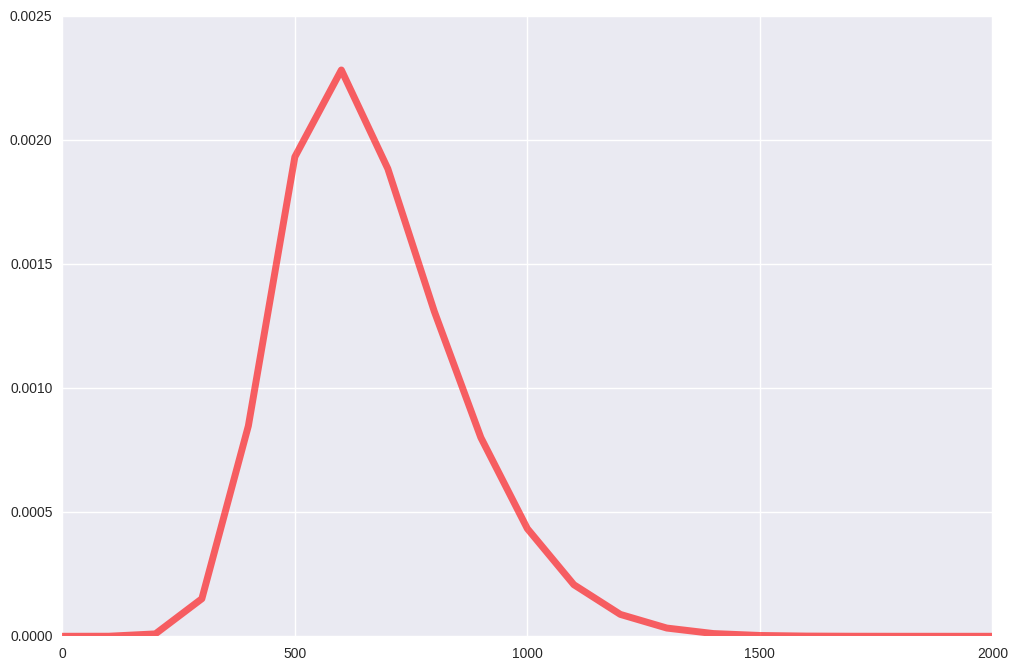

In [9]:
velsArr = numpy.arange(0.,2100.,100.)
shape, loc, scale = stats.skewnorm.fit(subSetVelDF["vSaps"])
pdf_fitted = stats.skewnorm.pdf(velsArr, shape, loc, scale)
print pdf_fitted

f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
# subSetProbDF.plot( x="vel_bin", y="prob", kind="bar", ax=ax )
ax.plot(velsArr, pdf_fitted, 'r-', lw=5, alpha=0.6)

In [6]:
# Define the fitting function
# We know that the velocities are 
# exhibiting a skew normal distribution
def fit_vel_pdf((mlt,mlat, dst, inpVels), a_ascmlt, b_ascmlt, a_bscmlt, b_bscmlt, a_cscmlt, b_cscmlt,\
               a_asclat, b_asclat, a_bsclat, b_bsclat,\
               a_ashmlt, b_ashmlt, a_bshmlt, b_bshmlt,\
               a_ashlat, b_ashlat, a_bshlat, b_bshlat,\
               a_alcmlt, b_alcmlt, a_blcmlt, b_blcmlt,\
               a_alclat, b_alclat, a_blclat, b_blclat):
    
    # model scale parameters
    # mlt
    a_scale_mlt = a_ascmlt + b_ascmlt * dst
    b_scale_mlt = a_bscmlt + b_bscmlt * dst
    c_scale_mlt = a_cscmlt + b_cscmlt * dst
    # mlat
    a_scale_mlat = a_asclat + b_asclat * dst
    b_scale_mlat = a_bsclat + b_bsclat * dst
    # func
    scale = ( a_scale_mlt + b_scale_mlt*(mlt) + c_scale_mlt*(mlt**2) ) * ( a_scale_mlat + b_scale_mlat*(mlat) )
    
    # model shape parameters
    # mlt
    a_shape_mlt = a_ashmlt + b_ashmlt * dst
    b_shape_mlt = a_bshmlt + b_bshmlt * dst
    # mlat
    a_shape_mlat = a_ashlat + b_ashlat * dst
    b_shape_mlat = a_bshlat + b_bshlat * dst
    # func
    shape = ( a_shape_mlt + b_shape_mlt*(mlt) ) * ( a_shape_mlat + b_shape_mlat*(mlat) )
    
    # model loc parameters
    # mlt
    a_loc_mlt = a_alcmlt + b_alcmlt * dst
    b_loc_mlt = a_blcmlt + b_blcmlt * dst
    # malt
    a_loc_mlat = a_alclat + b_alclat * dst
    b_loc_mlat = a_blclat + b_blclat * dst
    # func
    loc = ( a_loc_mlt + b_loc_mlt*(mlt) ) * ( a_loc_mlat*numpy.exp(b_loc_mlat*mlat) )
    
    # we need to adjust the skewnormal distribution
    # to account fot loc and scale parameters
    inpData = (inpVels - loc)/scale
    skNrml = 2*stats.norm.pdf(inpData)*stats.norm.cdf(shape*inpData)
     
    return skNrml.ravel()

initGuess = ( -1e+4, -1e+4, 1e3, 1e3, -10, -10,\
             100, 100, 10, 10,\
             1, 1, 10, 10,\
            -1, -1, 100, 100,\
            -100, -100, 100, 100,\
            4, 4, 0.1, 0.1)
popt2, pcov2 = curve_fit(fit_vel_pdf, (velGmagDF['MLAT'].T,velGmagDF['normMLT'].T,velGmagDF['dst_index'].T,\
                                       velGmagDF['vSaps'].T), velGmagDF['vSaps'], p0=initGuess)
print popt2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


[ -1.00000000e+04  -1.00000000e+04   1.00000000e+03   1.00000000e+03
  -1.00000000e+01  -1.00000000e+01   1.00000000e+02   1.00000000e+02
   1.00000000e+01   1.00000000e+01   1.00000000e+00   1.00000000e+00
   1.00000000e+01   1.00000000e+01  -1.00000000e+00  -1.00000000e+00
   1.00000000e+02   1.00000000e+02  -1.00000000e+02  -1.00000000e+02
   1.00000000e+02   1.00000000e+02   4.00000000e+00   4.00000000e+00
   1.00000000e-01   1.00000000e-01]


/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [7]:
aa = [ -1,1,2,2,2,3,4 ]
print stats.norm.cdf(aa)


[ 0.15865525  0.84134475  0.97724987  0.97724987  0.97724987  0.9986501
  0.99996833]
